# Background

We have a dataset of house sales from King County, which includes Seattle, for homes sold between May 2014 and May 2015. We will try to predict the sale price from the other predictors in the dataset. Here are the predictors:

| Predictor         | Description                                                                                                                                                                        |
|---------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| date          | Date of the home sale                                                                                                                                                                                |
| price         | Price of each home sold                                                                                                                                                                              |
| bedrooms      | Number of bedrooms                                                                                                                                                                                   |
| bathrooms     | Number of bathrooms, where .5 accounts for a room with a toilet but no shower                                                                                                                        |
| sqft_living   | Square footage of the apartments interior living space                                                                                                                                               |
| sqft_lot      | Square footage of the land space                                                                                                                                                                     |
| floors        | Number of floors                                                                                                                                                                                     |
| waterfront    | A dummy variable for whether the apartment was overlooking the waterfront or not                                                                                                                     |
| view          | An index from 0 to 4 of how good the view of the property was                                                                                                                                        |
| condition     | An index from 1 to 5 on the condition of the apartment                                                                                                                                              |
| grade         | An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design. |
| sqft_above    | The square footage of the interior housing space that is above ground level                                                                                                                          |
| sqft_basement | The square footage of the interior housing space that is below ground level                                                                                                                          |
| yr_built      | The year the house was initially built                                                                                                                                                               |
| yr_renovated  | The year of the house’s last renovation                                                                                                                                                              |
| zipcode       | What zipcode area the house is in                                                                                                                                                                    |
| lat           | Latitude                                                                                                                                                                                             |
| long          | Longitude                                                                                                                                                                                            |
| sqft_living15 | The square footage of interior housing living space for the nearest 15 neighbors                                                                                                                     |
| sqft_lot15    | The square footage of the land lots of the nearest 15 neighbors                                                                                                                                      |

# tl;dr / Summary

1\. What is our final model?

$$
\begin{align*}
log(\text{price}) \: =  -0.02 \: log(\text{sqft_lot}) &+ 0.02 \: log(\text{sqft_basement}) + (0.08 + 0.01 \: \text{bedrooms}) \: \text{floors} - 0.01 \: \text{bedrooms} \\
&+ 0.11 \: \text{bathrooms} + 0.39 \: \text{waterfront} + 0.04 \: \text{view} + 0.05 \: \text{condition} \\
&+ 0.23 \: \text{grade} - 0.01 \: \text{yr_built} + 21.5
\end{align*}
$$

2\. What is its interpretation?

- For the `log()` predictors, such as `log(sqft_basement)`, if `sqft_basement` increases by 10%, `price` increases by $1.10^{0.02} = 2\%$, holding all other variables constant.
- For the non-`log()` predictors, such as `bathrooms`, if `bathrooms` increases by 1, `price` increases by $e^{0.11} = 17\%$, holding all other variables constant.

Some notable findings:
- These predictors have a negligble effect on `price`:
    - `sqft_living15`
    - `yr_renovated`
    - `days_from_beg`
- The two most signficant predictors are `waterfront` and `grade`. 
    - A waterfront property is associated with a $e^{0.39} = 48\%$ increase in `price`.
    - An increase in [grade](http://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#g) is associated with a $e^{0.23} = 26\%$ increase in `price`.
  
3\. How good is the model?

Its $R^2$ value is 65%, and its residual standard error (RSE) is 0.31.

That is to say, 65% of the variability in `price` can be explained by the predictors. The average amount that our predicted $\widehat{log(\text{price}_i)}$ differs from $log(\text{price}_i)$ is, on average, 0.31.

In [441]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
sns.set_context("paper")

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.outliers_influence import variance_inflation_factor
from io import StringIO
from pprint import pprint
import arrow

In [442]:
def get_rse(est):
    return (est.ssr / (est.nobs - 2))**0.5

def get_vif(exog, exog_label_or_idx):
    """Now works w DataFrames, and adds the intercept column."""
    assert type(exog) == pd.DataFrame
    assert type(exog_label_or_idx) in (str, int)
    
    if type(exog_label_or_idx) == str:
        exog_idx = list(exog.columns).index(exog_label_or_idx)
    else:
        exog_idx = exog_label_or_idx
    
    exog_w_intercept = sm.add_constant(exog.as_matrix(), prepend=False)
    return variance_inflation_factor(exog_w_intercept, exog_idx)

def get_vifs(df, response):
    """Input the df and response column, and get the variance inflation factors for each of the predictors."""
    answer = {}
    cols = [i for i in df.columns if i != response]
    
    for col in cols:
        answer[col] = get_vif(df.drop(response, axis=1), col)
    
    return pd.Series(answer).sort_values(ascending=False)

def extract_coef_series(est):
    multiple = est.summary().tables[1]
    df = pd.read_csv(StringIO(multiple.as_csv()), index_col=0).iloc[:,0]
    df.index = [i.rstrip() for i in df.index]
    
    return df

def make_resid_plot(df, est, y):
    """X-axis, tho not labeled, is obs #. Like Figure 3.10 in ISLR."""
    df = df.copy()
    df['resid'] = df[y] - est.fittedvalues
    
    ax = sns.regplot(pd.np.arange(len(df)), df.resid, fit_reg=False)    
    ax.axhline(y=0, linestyle='dotted', color='black')
    
    return ax

def make_output(est):
    print('R^2 =', est.rsquared)
    print('RSE =', get_rse(est))
    return est.summary().tables[1]    

# def make_prediction_interval(est, alpha=0.05, **kwargs):
#     # TODO: fix this so that kwarg order matters
#     y_pred = est.predict(kwargs)[0]
    
#     df = pd.DataFrame.from_dict(kwargs, orient='index').T
#     X = sm.add_constant(df)

#     se, lower, upper = wls_prediction_std(est, X, alpha=alpha)

#     return y_pred, lower[0], upper[0]

# Step 0: Pre-processing / exploratory data analysis

These predictors wouldn't work in the linear regression model:
- lat
- long
- id
- zipcode
    - It would work if I created a feature such as distance to metro center, but by itself it doesn't.
- date
    - I transformed into a more interpretable metric, `days_from_beg`(inning).
    
Let's remove them from the DataFrame.

In [365]:
house = pd.read_csv('~/Downloads/Data/kc_house_data.csv', na_values='?').dropna()
house['date'] = house['date'].apply(lambda x: arrow.get(x, 'YYYYMMDD').date())
house['days_from_beg'] = house.date - house.date.min()
house['days_from_beg'] = house['days_from_beg'].apply(lambda x: x.days)

house = house.drop(['lat', 'long', 'id', 'zipcode', 'date'], axis=1)
house.head(2)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,days_from_beg
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,1340,5650,164
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,1690,7639,221


In [108]:
# house.iloc[0]

# Step 1: Trying a naive model that includes all predictors

In [244]:
est = smf.ols('price ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + waterfront + view + condition + grade + sqft_above + sqft_basement + yr_built + yr_renovated + sqft_living15 + sqft_lot15 + days_from_beg', house).fit()
make_output(est)

R^2 = 0.654698029484
RSE = 215737.744526


,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,-9.489e+05,1.9e+04,-50.002,0.000,-9.86e+05 -9.12e+05
bedrooms,-3.943e+04,2023.879,-19.481,0.000,-4.34e+04 -3.55e+04
bathrooms,4.595e+04,3487.649,13.175,0.000,3.91e+04 5.28e+04
sqft_living,109.2601,2.432,44.935,0.000,104.494 114.026
sqft_lot,-0.0043,0.051,-0.084,0.933,-0.105 0.096
floors,2.736e+04,3779.117,7.239,0.000,2e+04 3.48e+04
waterfront,5.787e+05,1.86e+04,31.092,0.000,5.42e+05 6.15e+05
view,4.296e+04,2270.313,18.924,0.000,3.85e+04 4.74e+04
condition,2.064e+04,2497.566,8.264,0.000,1.57e+04 2.55e+04
grade,1.201e+05,2246.523,53.450,0.000,1.16e+05 1.24e+05


### Interpretation

- There _is_ a statistically signficant effect of the predictors on `price`, as the p-value of the F-statistic is very low.
- $R^2$ is 65.5%, meaning that 65.5% of the variance in `price` is explained by the predictors.
- The residual squared error (RSE) is \$215,737, meaning that the best-fit prediction is off from the true value by about \$215,737 on average.
- Each of the predictors except for `sqft_lot` are statistically signficant, meaning that we reject the null hypothesis that that predictor has 0 effect in `price` for a unit change of that predictor.

# Step 2: Verifying linear regression assumptions and performing model fit diagnostics

## A. Verifying linearity of response-predictor relationships

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.3 µs


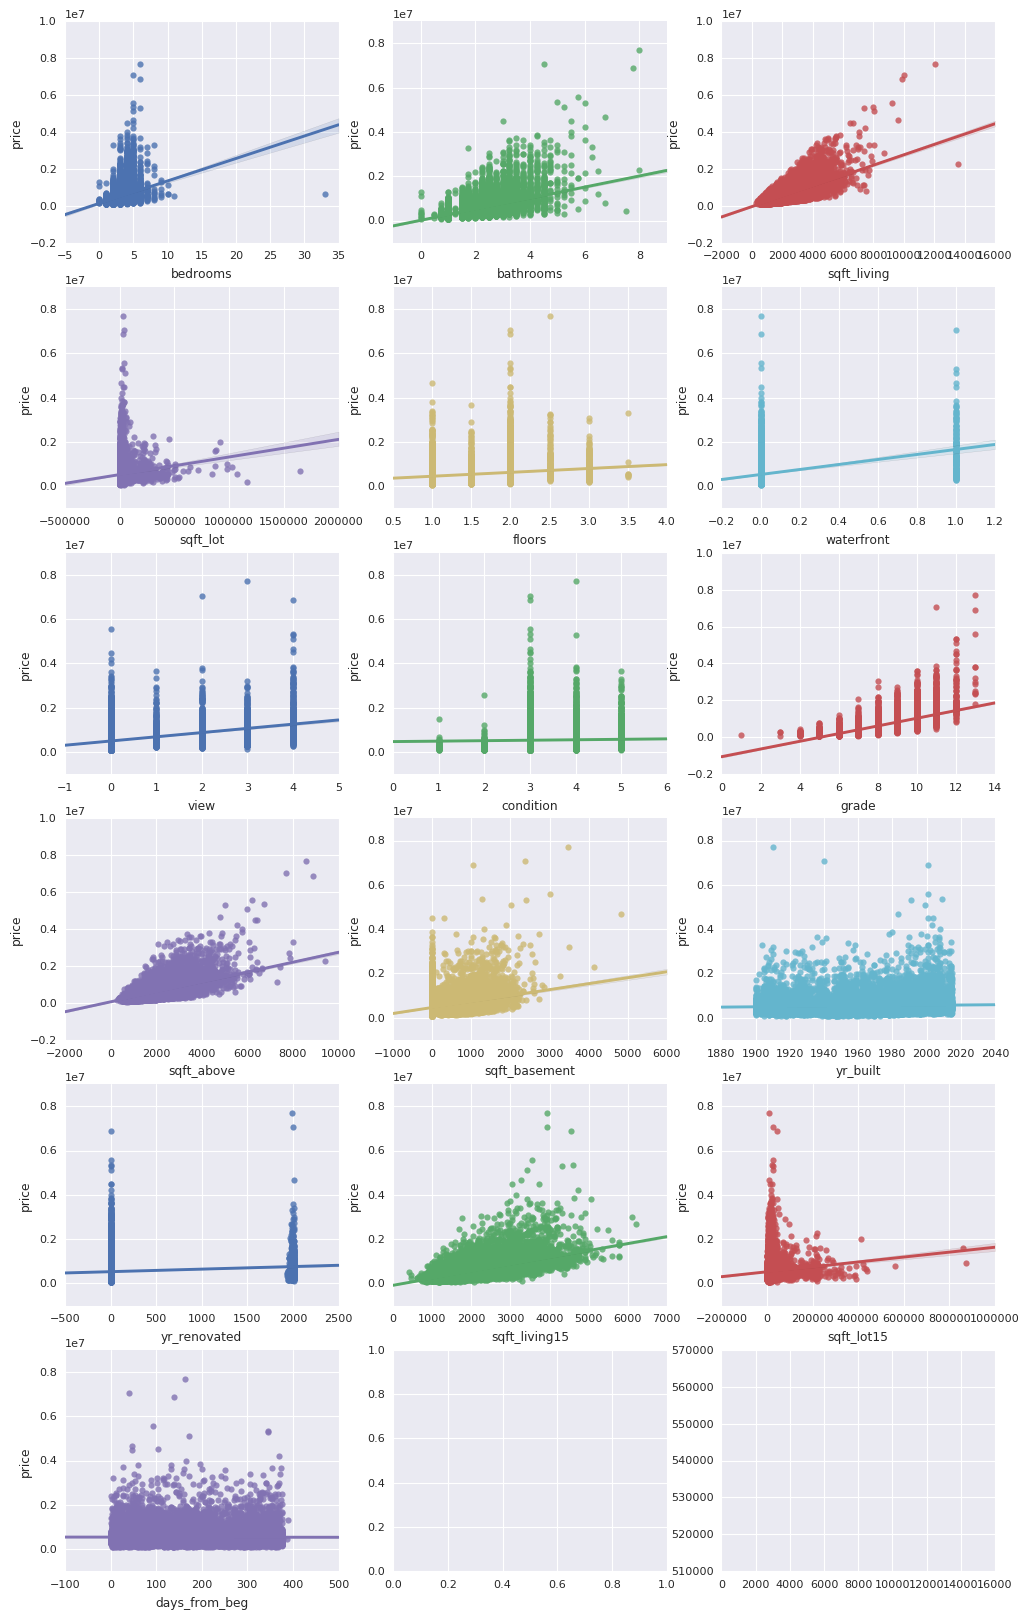

In [172]:
f, ax = plt.subplots(6, 3, figsize=(12,20))

# http://stackoverflow.com/questions/952914/making-a-flat-list-out-of-list-of-lists-in-python
axs = [item for sublist in ax for item in sublist]

for i, col in enumerate([i for i in house.columns if i != 'price']):
    sns.regplot(house[col], house.price, ax=axs[i], scatter_kws={'alpha': 0.3})

By a visual inspection, a linear assumption between most of the predictors and `price` seems appropriate. 

The predictors that visually look most likely to fit a quadratic trend are `bathrooms`, `sqft_living`, `sqft_above`, and `sqft_living15`, but even these don't look to have a strong quadratic relationship.  They instead seem to have weak (i.e. low $r$) linear relationships.

Some of the predictors are also heavily left-skewed, and may be less appropriate for a linear model: `sqft_lot`, `sqft_basement`, and `sqft_lot15`. Let's transform them and see if they have more linear fits.

We will also add "padding" to `sqft_basement` since if there is no basement, `log(0) = -infinity`.

In [416]:
house['sqft_basement'] = house['sqft_basement'] + 0.01

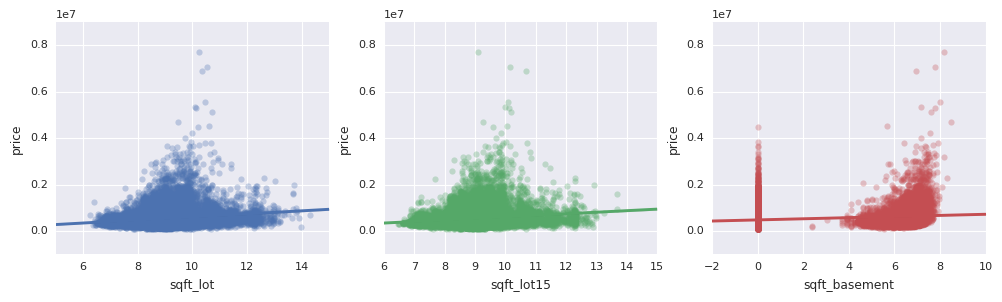

In [417]:
f, ax = plt.subplots(1, 3, figsize=(12,3))

sns.regplot(np.log(house.sqft_lot), house.price, ax=ax[0], scatter_kws={'alpha': 0.3})
sns.regplot(np.log(house.sqft_lot15), house.price, ax=ax[1], scatter_kws={'alpha': 0.3})
sns.regplot(np.log(house.sqft_basement), house.price, ax=ax[2], scatter_kws={'alpha': 0.3})

These transformations look more linear and less left-skewed than previously. Let's update our model and see the results.

In [394]:
est2 = smf.ols('price ~ np.log(sqft_lot15) + np.log(sqft_lot) + np.log(sqft_basement) + bedrooms + floors + sqft_living15 + sqft_living + bathrooms + waterfront + view + condition + grade + sqft_above + yr_built + yr_renovated + days_from_beg', house).fit()
make_output(est2)

R^2 = 0.660539610559
RSE = 213905.109312


,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,6.446e+06,1.38e+05,46.749,0.000,6.18e+06 6.72e+06
np.log(sqft_lot15),-2.37e+04,4624.081,-5.126,0.000,-3.28e+04 -1.46e+04
np.log(sqft_lot),-2.402e+04,4228.231,-5.681,0.000,-3.23e+04 -1.57e+04
np.log(sqft_basement),-454.1315,558.017,-0.814,0.416,-1547.887 639.624
bedrooms,-3.8e+04,1999.190,-19.010,0.000,-4.19e+04 -3.41e+04
floors,-6493.9895,4115.469,-1.578,0.115,-1.46e+04 1572.634
sqft_living15,37.2868,3.631,10.268,0.000,30.169 44.405
sqft_living,170.4951,7.151,23.843,0.000,156.479 184.511
bathrooms,4.029e+04,3498.895,11.515,0.000,3.34e+04 4.71e+04
waterfront,5.975e+05,1.85e+04,32.337,0.000,5.61e+05 6.34e+05


### Interpretation
- This model resolves the non-linearity of `sqft_lot`, `sqft_lot15`, and `sqft_basement` with `price` in the previous model.
- This model fits better than the previous one, with an $R^2$ of 66.1% compared to 65.5%, and an RSE of \$213,905 compared to \$215,738.
- Whereas in the previous model, `sqft_lot` was not statistically significant ($p = 0.93$), in this model `floors`, `log(sqft_basement)`, and `sqft_above` are not statistically significant.

## B. Homoskedacity / constant variance of error terms

Looking at the same graphic as for (A), we visually see heteroskedacity for `bedrooms`, `bathrooms`, `sqft_living`, `log(sqft_lot)`, `sqft_above`, `log(sqft_basement)`, `sqft_living15`, and `log(sqft_lot15)`.

One quick and dirty way to address heteroskedacity is to transform `price`. Let's try `log(price)` instead and see if the results are more homoskedastic.

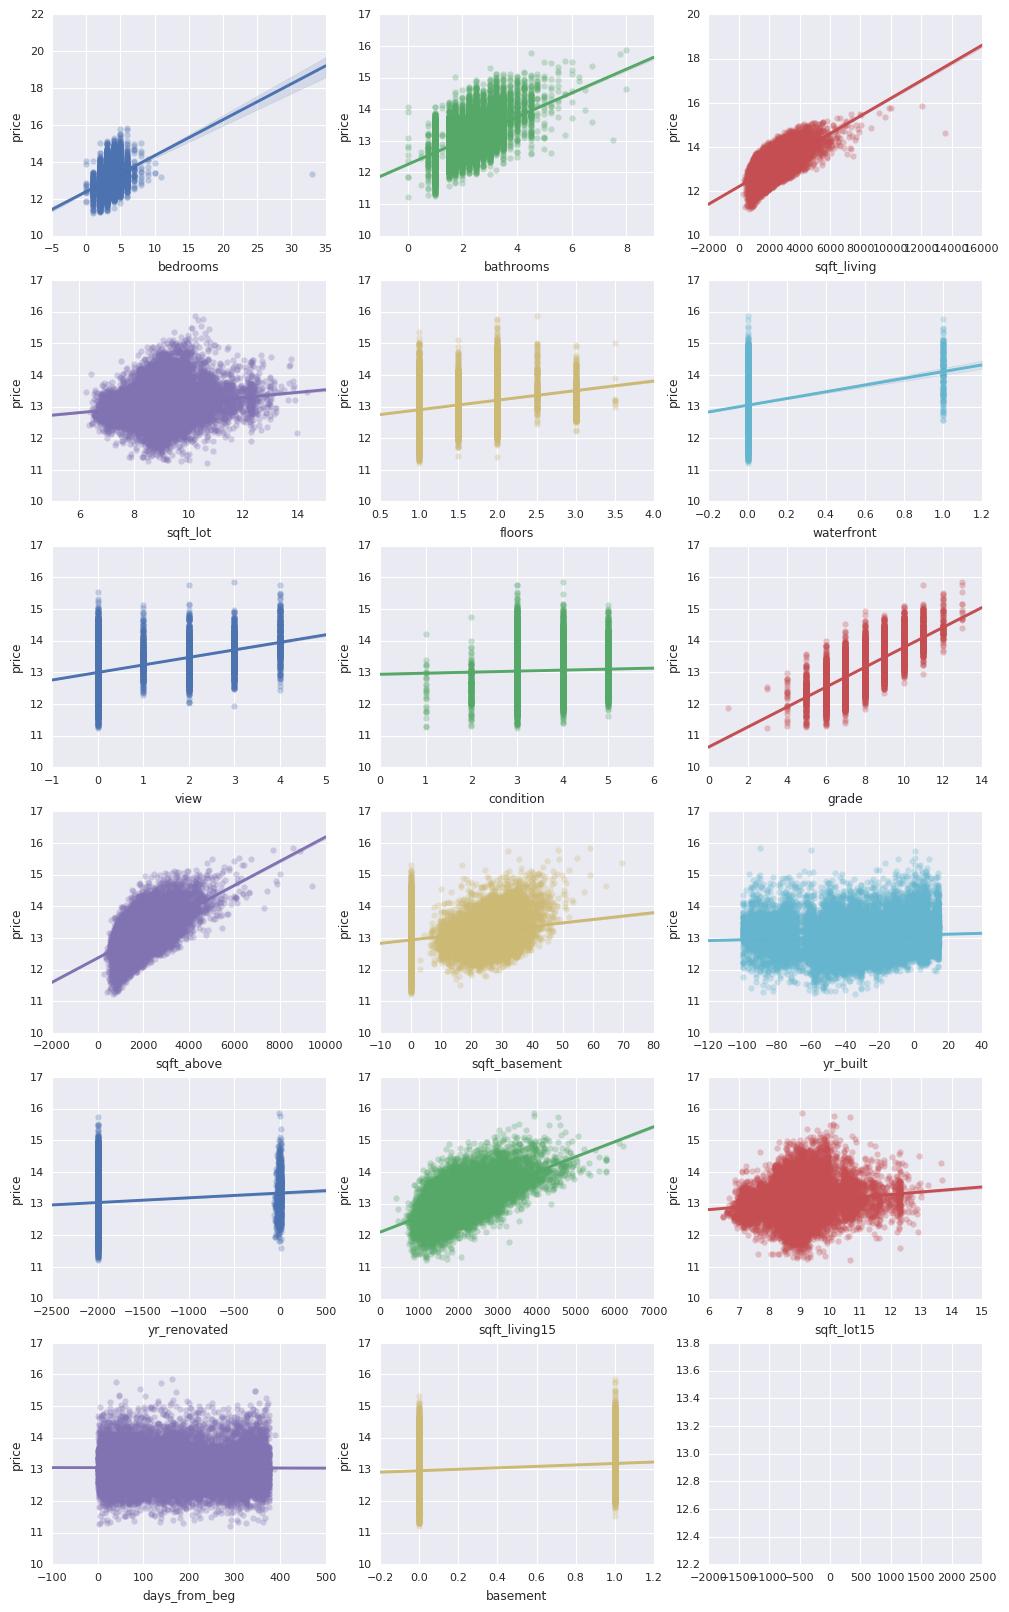

In [327]:
f, ax = plt.subplots(6, 3, figsize=(12,20))

# http://stackoverflow.com/questions/952914/making-a-flat-list-out-of-list-of-lists-in-python
axs = [item for sublist in ax for item in sublist]

for i, col in enumerate([i for i in house.columns if i != 'price']):
    if col in ('sqft_lot', 'sqft_lot15', 'sqft_basement'):
        x = np.log(house[col])
    else:
        x = house[col]
        
    sns.regplot(x, np.log(house.price), ax=axs[i], ci=False, scatter_kws={'alpha': 0.3})

From a visual inspection, many of the predictors are more homoskedastic, although `bedrooms`, `log(sqft_lot)`, and `log(sqft_lot15)` still exhibit some heteroskedacity.

Let's re-fit our model to the updated `log(price)`.

In [418]:
est3 = smf.ols('np.log(price) ~ np.log(sqft_lot15) + np.log(sqft_lot) + np.log(sqft_basement) + bedrooms + floors + sqft_living15 + sqft_living + bathrooms + waterfront + view + condition + grade + sqft_above + yr_built + yr_renovated + days_from_beg', house).fit()
make_output(est3)

R^2 = 0.66427483755
RSE = 0.305177525527


,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,21.2598,0.197,107.892,0.000,20.874 21.646
np.log(sqft_lot15),-0.0498,0.007,-7.548,0.000,-0.063 -0.037
np.log(sqft_lot),-0.0080,0.006,-1.322,0.186,-0.020 0.004
np.log(sqft_basement),0.0209,0.001,14.108,0.000,0.018 0.024
bedrooms,-0.0221,0.003,-7.752,0.000,-0.028 -0.017
floors,0.0807,0.006,13.750,0.000,0.069 0.092
sqft_living15,0.0001,5.18e-06,25.010,0.000,0.000 0.000
sqft_living,6.4e-05,1.09e-05,5.860,0.000,4.26e-05 8.54e-05
bathrooms,0.0608,0.005,12.169,0.000,0.051 0.071
waterfront,0.3804,0.026,14.429,0.000,0.329 0.432


### Interpretation
- We've addressed the heteroskedacity from the previous model, and now our predictors are more homoskedastic than before.
- The $R^2$ has improved, from 66.1% to 66.4%.
- All of the predictors are statistically significant except for `log(sqft_lot)`

## C. Correlation of error terms
The standard error terms for each of the predictors assume uncorrelated error terms. Let's verify this assumption.

Before looking at the data, we don't have reason to believe the error terms would be correlated. We don't expect any major seasonal trends (as they are mixed in with the noise from the other predictors), and similarly for groups or clusters of data points.

(0, 21613)

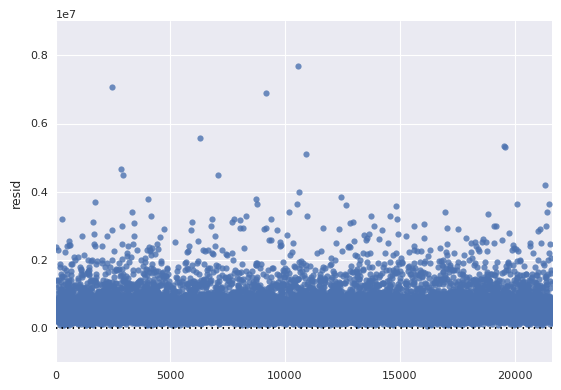

In [363]:
ax = make_resid_plot(house.sort_values('days_from_beg'), est3, y='price')
ax.set_xlim([0, len(house)])

# start = 15000
# ax.set_xlim([start, start + 1000])

From the above bird's eye view, there are no clear time series or other correlation of error terms.

## D. Checking for outliers and high-leverage points

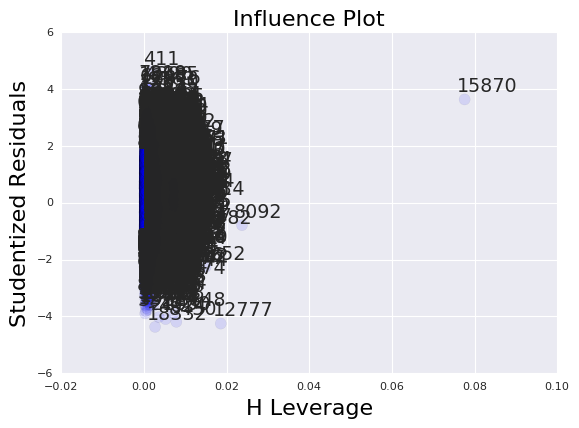

In [448]:
sm.graphics.influence_plot(est3, alpha=10E-2, plot_alpha=0.1, size=8, criterion='cooks');

There are a couple points which are outliers, data points that are more than 3 studentized residuals away from the mean. They don't affect the best-fit line, since they don't have high leverage, but they do lower the RSE and make the p-value higher than it would have been. 

There is also a single high-leverage _and_ outlier point, 15870. This point does affect the best-fit line in addition to 'artificially' raising the p-value, since it's an outlier. Looking at the data point, the house has 33 bedrooms for 1,620 sq ft of space.

This is most likely a data entry error, and my subjective opinion is to remove that row.

In [459]:
house.iloc[15870-2:15870+2, :11]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above
15868,570000.0,4,3.50,3990,23544,1.0,0,2,3,10,2300
15869,362000.0,3,2.50,2310,7485,2.0,0,0,3,8,2310
15870,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040
15871,172500.0,3,1.00,1140,8800,1.0,0,0,3,7,1140


## E: Checking for collinearity

In [399]:
house2 = house.copy()
house2['sqft_lot'] = np.log(house2['sqft_lot'])
house2['sqft_lot15'] = np.log(house2['sqft_lot15'])
house2['sqft_basement'] = np.log(house2['sqft_basement'])

In [400]:
get_vifs(house2, 'price')

sqft_living      20.359800
sqft_above       20.066422
sqft_lot          6.872123
sqft_lot15        6.671668
sqft_basement     4.298970
bathrooms         3.427507
grade             3.289937
sqft_living15     2.923915
floors            2.331092
yr_built          2.044072
bedrooms          1.631860
view              1.404754
condition         1.236962
waterfront        1.206448
yr_renovated      1.148971
days_from_beg     1.006660
dtype: float64

As a rule of thumb, a VIF greater than 5 indicates a problematic amount of co-linearity.

We see by looking at the variance inflation factors that `sqft_living`, `sqft_lot`, `sqft_lot15`, and `sqft_above` are extremely related to each other. This is a problem because it is now harder to say that `sqft_living` affects `price` by a certain amount, since `sqft_living` is closely associated with another predictor.

A simple way to mitigate the colinear predictors is to remove them, and check the resulting $R^2$ value.

In [410]:
get_vifs(house2.drop(['sqft_living', 'sqft_lot15', 'sqft_above'], axis=1), 'price')

bathrooms        2.955038
grade            2.777381
sqft_living15    2.528773
floors           2.105575
yr_built         1.992987
bedrooms         1.463609
sqft_lot15       1.442863
sqft_basement    1.404873
view             1.376981
condition        1.226089
waterfront       1.205385
yr_renovated     1.147800
days_from_beg    1.006406
dtype: float64

Now that we've removed the colinear predictors, let's look at the status of our updated model.

In [422]:
est4 = smf.ols('np.log(price) ~ np.log(sqft_lot) + np.log(sqft_basement) + bedrooms + floors + bathrooms + sqft_living15 + waterfront + view + condition + grade + yr_built + yr_renovated + days_from_beg', house).fit()
make_output(est4)

R^2 = 0.65336484619
RSE = 0.310096527625


,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,21.5427,0.200,107.789,0.000,21.151 21.934
np.log(sqft_lot),-0.0243,0.003,-8.682,0.000,-0.030 -0.019
np.log(sqft_basement),0.0178,0.001,22.145,0.000,0.016 0.019
bedrooms,-0.0002,0.003,-0.085,0.932,-0.006 0.005
floors,0.1147,0.006,20.050,0.000,0.104 0.126
bathrooms,0.1072,0.005,22.695,0.000,0.098 0.116
sqft_living15,0.0002,4.85e-06,35.448,0.000,0.000 0.000
waterfront,0.3903,0.027,14.585,0.000,0.338 0.443
view,0.0400,0.003,12.381,0.000,0.034 0.046
condition,0.0475,0.004,13.233,0.000,0.040 0.054


### Intepretation
- $R^2$ has gotten worse, from 66.4% to 65.3%, but this is to be expected since the current model has fewer predictors.
- RSE has also gotten slightly worse, from 0.305 to 0.310.
- It is now easier to say that `log(sqft_lot)`, for example, affects `log(price)` by its coefficient value, since all the predictors now are independent of each other, using the yardstick of a VIF of less than five.
- All the predictors are statistically significant except for `bedrooms`.

In [424]:
# house.head().sort_index(axis=1).iloc[:,7:13]

# Step 3: Trying to make all predictors statistically significant via interaction terms

Let's say that the effect of `bedrooms` on `log(price)` is _not_ independent of the effect of `floors` on `log(price)`, and that higher `bedrooms` and `floors` for one house will synergistically increase `log(price)` more than from each of their effects alone.

We can incorporate this idea into our model by including the interaction term of the product of those two predictors.

In [425]:
est5 = smf.ols('np.log(price) ~ np.log(sqft_lot) + np.log(sqft_basement) + bedrooms * floors + sqft_living15 + bathrooms + waterfront + view + condition + grade + yr_built + yr_renovated + days_from_beg', house).fit()
make_output(est5)

R^2 = 0.653436307688
RSE = 0.310064561588


,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,21.5044,0.201,107.162,0.000,21.111 21.898
np.log(sqft_lot),-0.0247,0.003,-8.794,0.000,-0.030 -0.019
np.log(sqft_basement),0.0181,0.001,22.126,0.000,0.017 0.020
bedrooms,-0.0139,0.007,-1.976,0.048,-0.028 -0.000
floors,0.0838,0.016,5.333,0.000,0.053 0.115
bedrooms:floors,0.0095,0.004,2.110,0.035,0.001 0.018
sqft_living15,0.0002,4.87e-06,35.081,0.000,0.000 0.000
bathrooms,0.1062,0.005,22.340,0.000,0.097 0.115
waterfront,0.3905,0.027,14.596,0.000,0.338 0.443
view,0.0402,0.003,12.417,0.000,0.034 0.046


### Interpretation
- $R^2$ and RSE are about the same as previously.
- All predictors are now statistically significant.

# Step 4: Next steps / future work

- Cross-validation to reduce overfitting.
- Create confidence interval function and prediction interval function and add to tl;dr.
    - answer Q "How accurately can we predict the future price of a house?"